In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2@family=JetBrains+Mono:wght@300@display=swap');
* {
    font-family: 'JetBrains Mono', monospace;
}
</style>

# Setup
`python3 -m pip install pyreadr, numpy, pandas, matplotlib, seaborn, scipy, imbalanced-learn, scikit-learn, shap`

In [2]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import imblearn
from sklearn.preprocessing import LabelEncoder

*rdata* is a file format used for the **R** language. To read the data contained, we need to use the `pyreadr` package.

In [3]:
data_file = '../5v_cleandf.rdata'
r_format = pyreadr.read_r(data_file)
df = r_format['df']  # df is the dataset contained in the file
df.head().T

,0,1,2,3,4
dep_name,B,B,B,A,A
esi,4,4,2,2,3
age,40,66,66,66,84
gender,Male,Male,Male,Male,Female
ethnicity,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino
...,...,...,...,...,...
cc_woundcheck,0,0,0,0,0
cc_woundinfection,0,0,0,0,0
cc_woundre-evaluation,0,0,0,0,0
cc_wristinjury,0,0,0,0,0


The dataset is too large to work with fast, so we can condense it only to the columns that are related.

In [4]:
columns = ['esi',
           'age',
           'gender',
           'ethnicity',
           'race',
           'lang',
           'religion',
           'maritalstatus',
           'employstatus',
           'insurance_status',
           'disposition',
           'arrivalmode',
           'previousdispo']

data = df.copy()[columns] # new dataframe with the selected columns

The dataset contains many `null` values, so we can simply remove any rows that contain a `null` value in it.

In [5]:
cols_in_dataframe = list(data.columns)

for col in cols_in_dataframe:
    rows_to_remove = []
    nulled_col = list(data[col].isnull())
    for i in range(len(nulled_col)):
        if nulled_col[i] == True:
            rows_to_remove.append(i)
    rows_to_remove.sort(reverse=True)
    
    data.drop(rows_to_remove, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print('Done condensing:', col)

Done condensing: esi
Done condensing: age
Done condensing: gender
Done condensing: ethnicity
Done condensing: race
Done condensing: lang
Done condensing: religion
Done condensing: maritalstatus
Done condensing: employstatus
Done condensing: insurance_status
Done condensing: disposition
Done condensing: arrivalmode
Done condensing: previousdispo


Label encoding makes the data easier for the model to work with. It takes the different values of a column and assigns an individual number to it.
<br />
Ex: `[a, b, a, a, c] => [0, 1, 0, 0, 2]`

In [6]:
%%capture
cont = ['esi', 'age']
cat = [
    'gender',
    'ethnicity',
    'race',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
    'previousdispo'
]

# Create individual label encoders for each column
transformers = {}
for col in cat:
    transformers[col] = LabelEncoder()

# fit each column with its corresponding label encoder
for col in cat:
    data[col] = data[[col]].apply(transformers[col].fit_transform)

The `esi` column is stored as strings, so we can convert the strings to numbers.

In [7]:
data['esi'] = data['esi'].astype(int)

Let's split the training and the testing data with the `sklearn` module.
We can split the large dataframe we have into **training** and **testing** dataframes with the `sklearn` module.
**Training** data is used to train the models, while **testing** data is used to test the accuracy of the model on data it hasn't seen before.

In [8]:
cols_to_train_on = [
    'esi', 'age', 'gender', 'ethnicity', 'race', 'lang', 'religion',
#     'maritalstatus', 'employstatus', 'insurance_status', 'disposition',
    'maritalstatus', 'employstatus', 'insurance_status',
    'arrivalmode'
]

# col_dep_var = [ 'previousdispo' ]
col_dep_var = [ 'disposition' ]

In [9]:
from sklearn.model_selection import train_test_split

`X` is going to be the dataframe with the columns that we want to train on.  
`y` is going to be the dataframe with the column of the dependent variable.

In [10]:
X = data[cols_to_train_on]
y = data[col_dep_var]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

The process above takes the two dataframes `X` and `y` which contain the <u>data the model will see</u> and the <u>data the model will try to predict</u>, respectively, and splits them into training and testing data with a ratio of **8:2**.

In [12]:
train = pd.DataFrame(X_train)
# train['previousdispo'] = y_train
train['disposition'] = y_train
train.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode,disposition
72403,3,49,0,1,7,0,1,4,1,0,4,1
523720,3,49,1,0,6,0,10,7,4,3,0,1
225701,4,37,0,1,7,0,8,7,1,0,6,1
314825,3,58,0,0,4,0,0,7,0,2,0,0
47228,3,74,1,1,7,0,1,4,5,0,0,0


In [13]:
test = pd.DataFrame(X_test)
# test['previousdispo'] = y_test
test['disposition'] = y_test
test.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode,disposition
125651,2,21,0,1,2,0,2,7,4,0,0,0
132800,4,71,0,1,7,0,1,4,4,0,0,1
120896,4,49,1,0,4,0,1,4,2,1,4,1
150527,2,84,0,1,2,0,10,9,5,2,0,1
168366,4,49,1,1,2,0,6,7,6,1,6,1


We consolidated the data back into `train` and `test` dataframes again, if we need the full dataframe for some reason.

In [14]:
# X_train = X_train.drop(columns='previousdispo')
X_train = X_train.drop(columns='disposition')
X_train.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode
72403,3,49,0,1,7,0,1,4,1,0,4
523720,3,49,1,0,6,0,10,7,4,3,0
225701,4,37,0,1,7,0,8,7,1,0,6
314825,3,58,0,0,4,0,0,7,0,2,0
47228,3,74,1,1,7,0,1,4,5,0,0


In [15]:
# X_test = X_test.drop(columns='previousdispo')
X_test = X_test.drop(columns='disposition')
X_test.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode
125651,2,21,0,1,2,0,2,7,4,0,0
132800,4,71,0,1,7,0,1,4,4,0,0
120896,4,49,1,0,4,0,1,4,2,1,4
150527,2,84,0,1,2,0,10,9,5,2,0
168366,4,49,1,1,2,0,6,7,6,1,6


# Implementing kNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier # import the module

In [17]:
knn = KNeighborsClassifier() # create the classifier

In [18]:
knn.fit(X_train, np.ravel(y_train)) # fit the classifier

KNeighborsClassifier()

In [19]:
preds = knn.predict(X_test) # predict

In [20]:
knn.score(X_test, y_test)

0.751086663129776

In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     33087
           1       0.80      0.85      0.83     74352

    accuracy                           0.75    107439
   macro avg       0.71      0.69      0.70    107439
weighted avg       0.74      0.75      0.75    107439



In [23]:
from sklearn.metrics import f1_score

In [24]:
f1_score(y_test, preds, average='macro')

0.6957553011101814

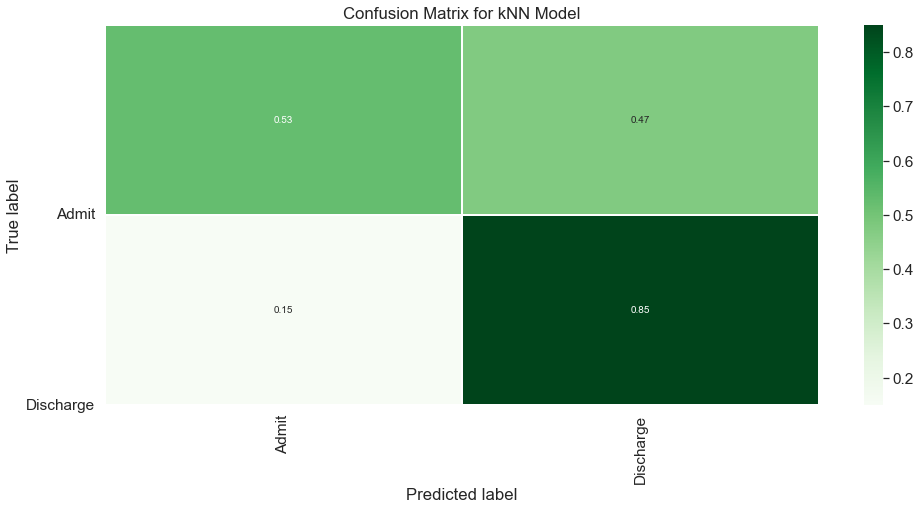

In [25]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# plot_labels = list(data['previousdispo'].unique())
plot_labels = list(data['disposition'].unique())
plot_labels.sort()
# plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
plot_labels_transformed = transformers['disposition'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for kNN Model')
plt.show()

# Implementing Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier # import the module

In [27]:
clf = DecisionTreeClassifier(random_state=42) # create the classifier

In [28]:
clf.fit(X_train, np.ravel(y_train)) # fit the classifier

DecisionTreeClassifier(random_state=42)

In [29]:
preds = clf.predict(X_test) # predict

In [30]:
clf.score(X_test, y_test)

0.7387633913197256

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59     33087
           1       0.82      0.80      0.81     74352

    accuracy                           0.74    107439
   macro avg       0.70      0.70      0.70    107439
weighted avg       0.74      0.74      0.74    107439



In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(y_test, preds, average='macro')

0.6982202275731331

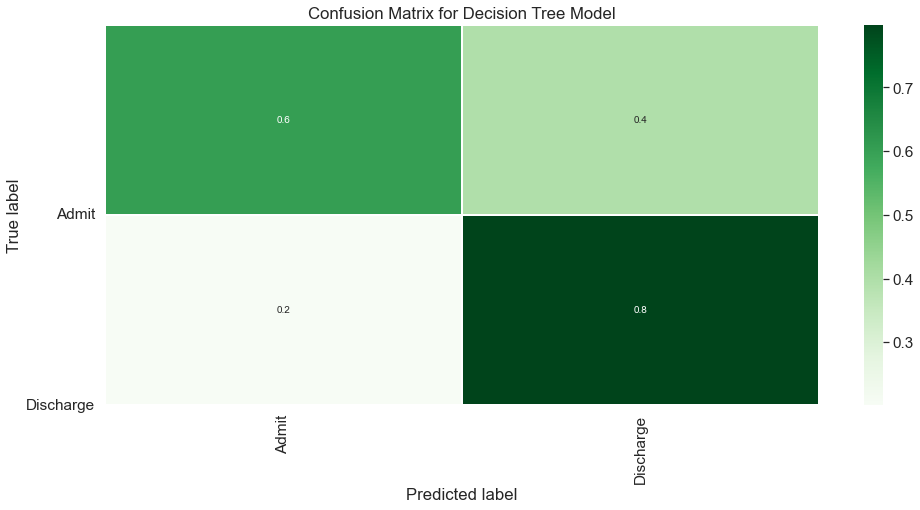

In [35]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# plot_labels = list(data['previousdispo'].unique())
plot_labels = list(data['disposition'].unique())
plot_labels.sort()
# plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
plot_labels_transformed = transformers['disposition'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

# Implementing Balanced RandomForest

### Getting params for balanced random forest

This random forest model was optimized using **bayesian optimization** (to very little avail), and the hyperparameters for the model are stored in a json file.

In [36]:
import json

In [37]:
params = dict()
with open('balanced_random_forest_classifier_params.conf', 'r') as fin:
    params = json.load(fin)

In [38]:
params # derived from bayesian optimization

{'max_features': 0.540182629147784,
 'max_samples': 0.5015089362645042,
 'n_estimators': 144.92138171132888}

### Implementing Classifier

In [39]:
from numpy import mean
from imblearn.ensemble import BalancedRandomForestClassifier # import the module

In [40]:
brc = BalancedRandomForestClassifier(
    max_samples=params['max_samples'],
    max_features=params['max_features'],
    n_estimators=int(params['n_estimators']),
    verbose=True,
    n_jobs=-1,
    random_state=42
) # create the classifier

In [41]:
brc.fit(X_train, np.ravel(y_train)) # fit the classifier

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   23.2s finished


BalancedRandomForestClassifier(max_features=0.540182629147784,
                               max_samples=0.5015089362645042, n_estimators=144,
                               n_jobs=-1, random_state=42, verbose=True)

In [42]:
preds = brc.predict(X_test) # predict

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    1.1s finished


In [43]:
brc.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    1.1s finished


0.7315872262400059

In [44]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64     33087
           1       0.87      0.72      0.79     74352

    accuracy                           0.73    107439
   macro avg       0.71      0.74      0.71    107439
weighted avg       0.77      0.73      0.74    107439



In [46]:
from sklearn.metrics import f1_score

In [47]:
f1_score(y_test, preds, average='macro')

0.712372842714081

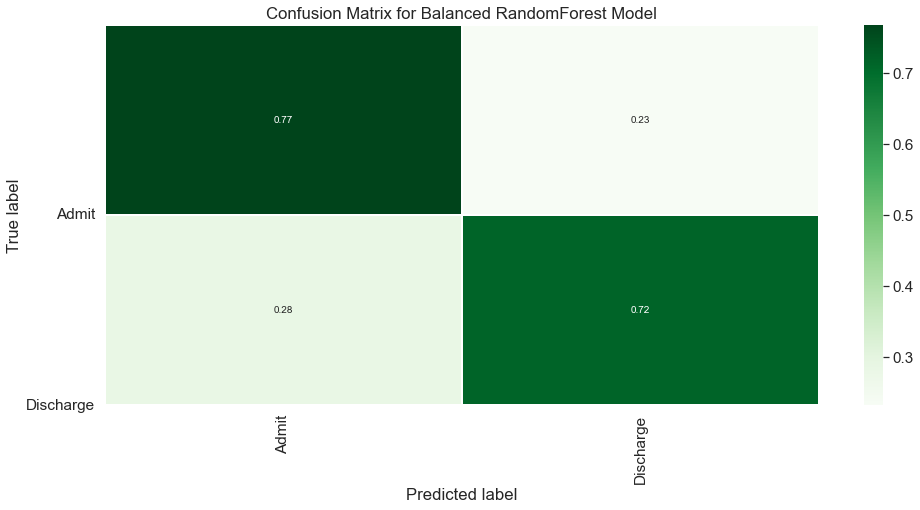

In [48]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# plot_labels = list(data['previousdispo'].unique())
plot_labels = list(data['disposition'].unique())
plot_labels.sort()
# plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
plot_labels_transformed = transformers['disposition'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Balanced RandomForest Model')
plt.show()

In [49]:
from sklearn.model_selection import cross_validate

In [50]:
scores = cross_validate(brc, X_train, y_train, cv=5, n_jobs=-1, scoring='f1_macro', verbose=2)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


{'fit_time': array([97.05283999, 89.29283738, 93.95884728, 90.47483754, 87.47684145]),
 'score_time': array([1.27400112, 6.09000587, 2.76499391, 4.90100479, 5.50300002]),
 'test_score': array([0.71218864, 0.71361294, 0.71277649, 0.71286064, 0.71455525])}

In [51]:
from sklearn.model_selection import cross_val_score

In [52]:
scores = cross_val_score(brc, X_train, y_train, cv=5, n_jobs=-1, scoring='f1_macro', verbose=3)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


array([0.71218864, 0.71361294, 0.71277649, 0.71285002, 0.71455525])

# Feature Importance

## Default

In [53]:
importances = brc.feature_importances_
importances

array([0.25416213, 0.3020833 , 0.02692014, 0.01714225, 0.034549  ,
       0.01187067, 0.10728279, 0.06154745, 0.06815331, 0.05542103,
       0.06086792])

In [54]:
std = np.std([tree.feature_importances_ for tree in brc.estimators_], axis=0)
std

array([0.04479116, 0.04200888, 0.00249741, 0.00125269, 0.00263925,
       0.00081291, 0.00385304, 0.00948047, 0.02514369, 0.00554862,
       0.02731338])

In [55]:
feature_names = list(X_train.columns)
feature_names

['esi',
 'age',
 'gender',
 'ethnicity',
 'race',
 'lang',
 'religion',
 'maritalstatus',
 'employstatus',
 'insurance_status',
 'arrivalmode']

In [56]:
forest_importances = pd.Series(importances, index=feature_names)

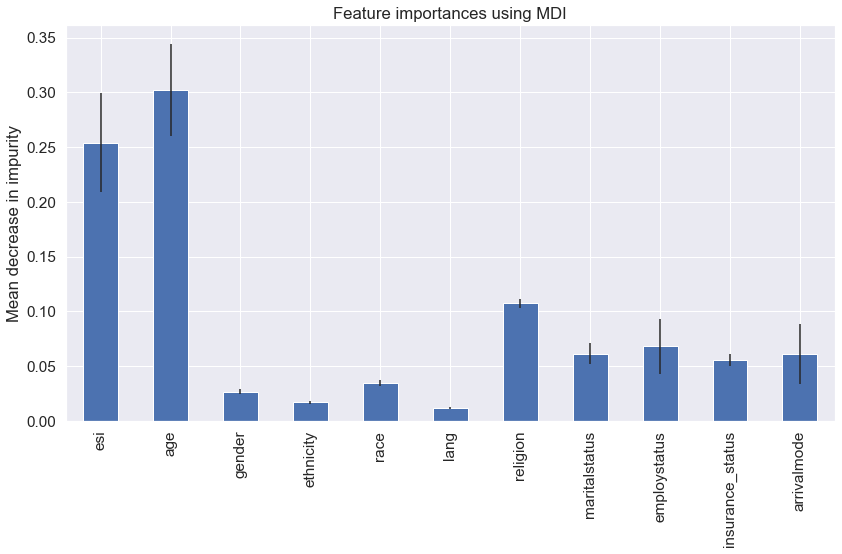

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Feature Permutation

In [58]:
from sklearn.inspection import permutation_importance

In [59]:
result = permutation_importance(
    brc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 144 out of 144 | elapsed:    1.2s finished


In [60]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [61]:
forest_importances

esi                 0.102360
age                 0.050142
gender              0.009467
ethnicity           0.000415
race                0.006580
lang                0.001699
religion            0.009663
maritalstatus       0.008665
employstatus        0.015275
insurance_status    0.018302
arrivalmode         0.018181
dtype: float64

In [62]:
result.importances_std

array([0.00095608, 0.0010491 , 0.00059316, 0.00021376, 0.00063389,
       0.00031366, 0.00057492, 0.0005234 , 0.00059504, 0.00072428,
       0.00058142])

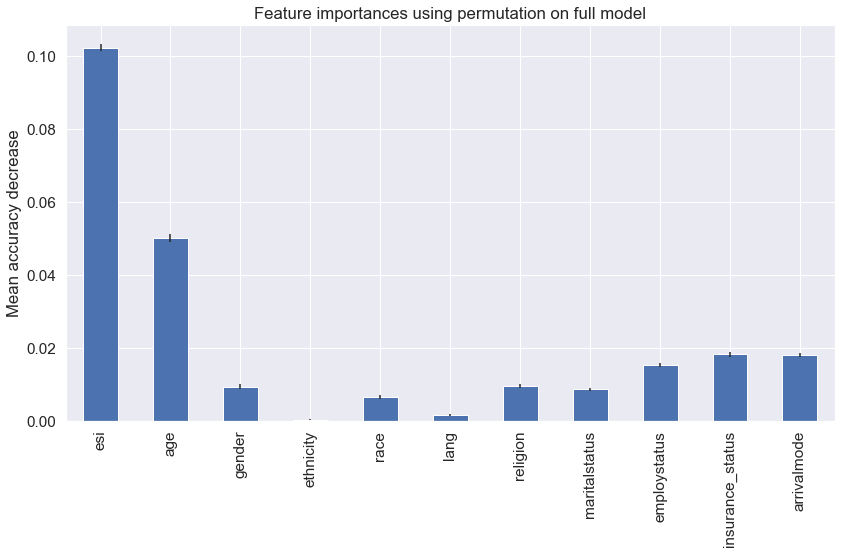

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
forest_importances.plot.bar(yerr=result.importances_std)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Relative Feature Importances

In [64]:
importances = brc.feature_importances_

In [65]:
indices = np.argsort(importances)

In [66]:
features = X_train.columns

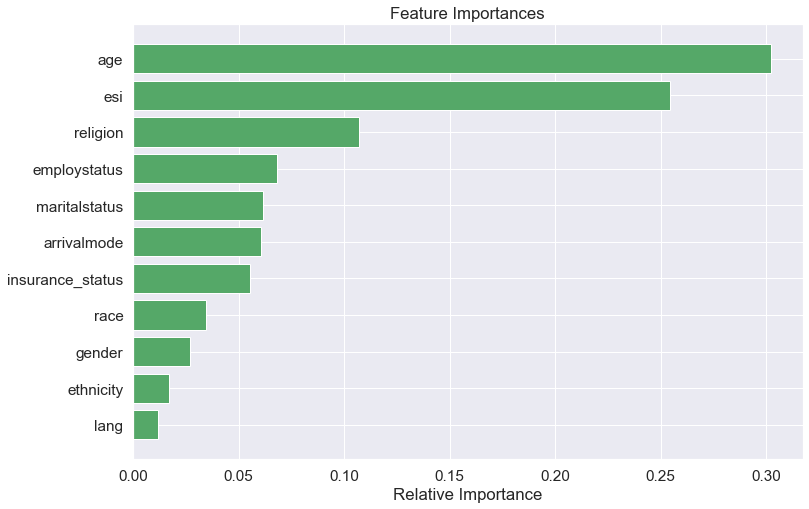

In [67]:
fig = plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# SHAP Values

In [68]:
import shap

In [69]:
X_test['age'] = X_test['age'].astype('int')

Patrick's `shap` model implemented with the `Balanced Random Forest Classifier`

`Explainer` was changed to `TreeExplainer` because we are using a **RandomForest** classifier, and **TreeExplainer** should yield faster run-times.

In [70]:
explainer = shap.Explainer(brc)

There are **107439** samples in `X_test`, and `shap` is computationally expensive, so we can use the explainer to explain the first **50** samples in `X_test`.

In [71]:
shap_values = explainer.shap_values(X_test[:50])

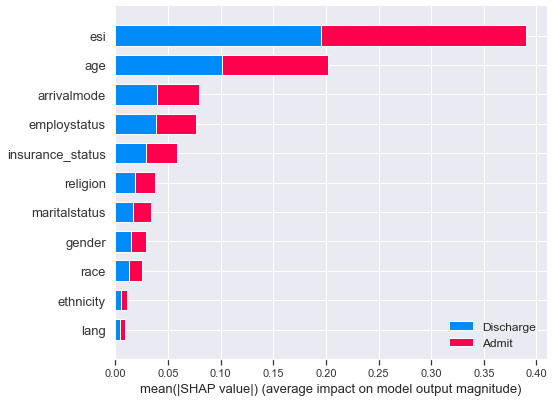

In [72]:
shap.summary_plot(
    shap_values,
    X_train.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_train.columns
)

In [73]:
shap.initjs()
i = 3
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_train.values[i], feature_names = X_train.columns)

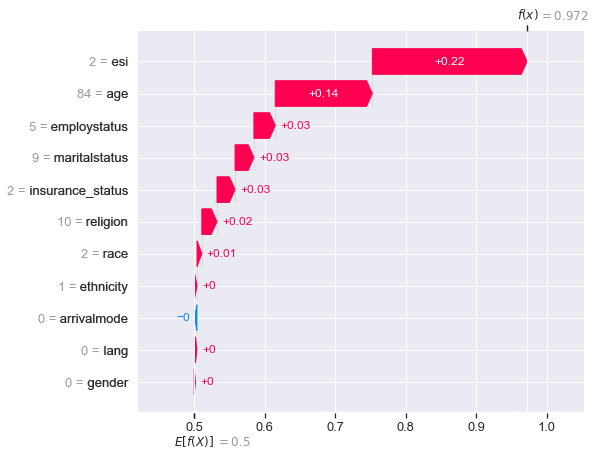

In [74]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)